In [1]:
from NID.datasets import Pinky40
from NID.models import DnCNN
from NID.utils import weights_init_kaiming, batch_PSNR

import numpy as np
import scipy.io as sio 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass

import os
import h5py
import random
import cv2
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tensorboardX import SummaryWriter 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

@dataclass
class training_configurations: 
    '''class for storing options of the netowrk training'''
    preprocess: bool = False  
    batchSize: int = 256    # training batch size 
    num_of_layers: int = 10 # number of total layers 
    epochs: int = 3   #number of training epochs 
    milestone: int = 1 # when to decay learning rate 
    lr: float = 1e-3  # initial learning rate 
    outf: str = 'logs' #path of log files 
    mode: str = 'S' #with known noise level (S) or blind training (B)
    noiseL: float = 0.1 # noise level
    val_noiseL: float = 0.1 # nosie level used on validation set 

# prepare data

In [3]:
dataset = Pinky100()

NameError: name 'Pinky100' is not defined

In [2]:
dataset_train = Pinky40(train=True)
print(type(dataset_train))
dataset_val = Pinky40(train=False)
loader_train = DataLoader(dataset=dataset_train, num_workers=4, 
                         batch_size=256, shuffle=True)
print("# of training samples: %d\n" % len(dataset_train))
print("# of testing samples: %d\n" % len(dataset_val))

the dirname is /data/home/app2139/NID/NID
<class 'NID.datasets.Pinky40'>
the dirname is /data/home/app2139/NID/NID
# of training samples: 213448

# of testing samples: 276



# configure training options

In [3]:
opt = training_configurations()
print(type(opt))
testOpt = opt.outf
print(testOpt)

<class '__main__.training_configurations'>
logs


# build model 

In [4]:
net = DnCNN(channels=1, num_of_layers=opt.num_of_layers)
# Move to GPU
device_ids = [0]
#initialize weights
file_results = os.path.join(opt.outf, 'net_{}_0point1NewDataS.pth'.format(opt.num_of_layers))
if os.path.exists(file_results):
    print("we entered the if")
    print('use the trained model as the initialization')
    model = nn.DataParallel(net, device_ids=device_ids).cuda()
    model.load_state_dict(torch.load(file_results))
    model.eval()
else:
    print("we entered the else")
    net.apply(weights_init_kaiming)
    print("we are now doing model = nn.DataParallel...")
    model = nn.DataParallel(net, device_ids=device_ids).cuda()
    print("we exit the else")
    
criterion = nn.MSELoss(reduction='sum')
criterion.cuda()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=opt.lr)
# training
writer = SummaryWriter(opt.outf)
step = 0
opt.lr = 1e-4

we entered the if
use the trained model as the initialization


# start training - GPU

In [6]:
for epoch in range(opt.epochs):
        if epoch < opt.milestone:
            current_lr = opt.lr
        else:
            current_lr = opt.lr / 10.
        # set learning rate
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        print('learning rate %f' % current_lr)
        # train
        for i, data in enumerate(loader_train, 0):
            # training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            img_train = data
            if opt.mode == 'S':
                noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=opt.noiseL)
            if opt.mode == 'B':
                noise = torch.zeros(img_train.size())
                stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
                for n in range(noise.size()[0]):
                    sizeN = noise[0,:,:,:].size()
                    noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
            imgn_train = img_train + noise
            img_train, imgn_train = Variable(img_train.cuda()), Variable(imgn_train.cuda())
            noise = Variable(noise.cuda())
            out_train = model(imgn_train)
            loss = criterion(out_train, noise) / (imgn_train.size()[0]*2)
            loss.backward()
            optimizer.step()
            # results
            model.eval()
            out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
            psnr_train = batch_PSNR(out_train, img_train, 1.)
            print("[epoch %d][%d/%d] loss: %.4f PSNR_train: %.4f" %
                (epoch+1, i+1, len(loader_train), loss.item(), psnr_train))
            # if you are using older version of PyTorch, you may need to change loss.item() to loss.data[0]
            if step % 10 == 0:
                # Log the scalar values
                writer.add_scalar('loss', loss.item(), step)
                writer.add_scalar('PSNR on training data', psnr_train, step)
            step += 1
        ## the end of each epoch
        model.eval()
        # validate
        psnr_val = 0
        for k in range(len(dataset_val)):
            img_val = torch.unsqueeze(dataset_val[k], 0)
            noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
            imgn_val = img_val + noise
            img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
            out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
            psnr_val += batch_PSNR(out_val, img_val, 1.)
        psnr_val /= len(dataset_val)
        print("\n[epoch %d] PSNR_val: %.4f" % (epoch+1, psnr_val))
        writer.add_scalar('PSNR on validation data', psnr_val, epoch)
        # log the images
#         out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
#         Img = utils.make_grid(img_train.data, nrow=8, normalize=True, scale_each=True)
#         Imgn = utils.make_grid(imgn_train.data, nrow=8, normalize=True, scale_each=True)
#         Irecon = utils.make_grid(out_train.data, nrow=8, normalize=True, scale_each=True)
#         writer.add_image('clean image', Img, epoch)
#         writer.add_image('noisy image', Imgn, epoch)
#         writer.add_image('reconstructed image', Irecon, epoch)
        # save model
        torch.save(model.state_dict(), os.path.join(opt.outf, 'net_{}.pth'.format(opt.num_of_layers)))


learning rate 0.000100
[epoch 1][1/834] loss: 32.3205 PSNR_train: 16.8717
[epoch 1][2/834] loss: 31.8563 PSNR_train: 16.8466
[epoch 1][3/834] loss: 31.5392 PSNR_train: 16.8560
[epoch 1][4/834] loss: 31.0924 PSNR_train: 16.8602
[epoch 1][5/834] loss: 30.7566 PSNR_train: 16.8688
[epoch 1][6/834] loss: 30.4676 PSNR_train: 16.8353
[epoch 1][7/834] loss: 30.0385 PSNR_train: 16.8430
[epoch 1][8/834] loss: 29.7016 PSNR_train: 16.8309
[epoch 1][9/834] loss: 29.3083 PSNR_train: 16.8469
[epoch 1][10/834] loss: 28.8119 PSNR_train: 16.8552
[epoch 1][11/834] loss: 28.4581 PSNR_train: 16.8576
[epoch 1][12/834] loss: 28.0682 PSNR_train: 16.8399
[epoch 1][13/834] loss: 27.5922 PSNR_train: 16.8511
[epoch 1][14/834] loss: 27.2345 PSNR_train: 16.8366
[epoch 1][15/834] loss: 26.7839 PSNR_train: 16.8336
[epoch 1][16/834] loss: 26.3449 PSNR_train: 16.8388
[epoch 1][17/834] loss: 25.8914 PSNR_train: 16.8185
[epoch 1][18/834] loss: 25.3613 PSNR_train: 16.8288
[epoch 1][19/834] loss: 24.9583 PSNR_train: 16.814

# test it on real data

In [5]:
data_path = os.path.join(dataset_train.root, 'testdata')
real_data = sio.loadmat(os.path.join(data_path, 'real_2pdata.mat'))
A2p = real_data['A']
A2p_corr = real_data['A_corr']
A2p_raw = real_data['A_raw']

In [6]:
def plot_2p_results(neuron_id, cmap='jet'): 
#     img_raw = A_corr[:, :, neuron_id]
    img_raw = A2p_raw[:,:,neuron_id]

    noise = img_raw.std()
    img_raw = img_raw[np.newaxis, np.newaxis, ...] / noise * 0.1
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A2p[:, :, neuron_id].squeeze()
    img_ai_raw = A2p_raw[:,:,neuron_id].squeeze()
    img_diff= img_ai_raw.squeeze() - img_ai
    
    img_diff = img_diff / noise * 0.1
    print(img_diff.shape)
    imgs = [img_raw.squeeze(), img_denoised.squeeze(), 
            img_output.squeeze(), img_ai/noise*0.1, img_diff]
    titles = ['unconstrained $a_i$', 'denoised $a_i$', 'residual', 'CNMF $a_i$', 'difference']
#     fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    plt.figure(figsize=(12, 8))
    vlims = [[-0.1,1], [-0.1,1], [-0.2, 0.2], [-0.1,1], [-0.2, 0.2]]
    for i, img, title, vlim in zip(range(len(imgs)), imgs, titles, vlims): 
        plt.subplot(2,5, i+1)
        im = plt.imshow(img, cmap=cmap, clim=vlim)
        plt.colorbar()
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.title(title)
#         plt.colorbar(im, cax=cax)
    
#     plt.tight_layout()
    
    imgs = imgs[0:2]
    labels = ['raw image', 'denoised image']
#     plt.figure(figsize=(5, 8))
    plt.subplot(2,2,3)
    for i, img, label in zip(range(len(imgs)), imgs, labels): 
        __ = plt.hist(img.flatten(), bins=np.linspace(-0.1,1, 100), 
                     label=label)
        plt.yscale('log')
        plt.legend()

    plt.subplot(2,2, 4)
    plt.plot(img_raw.ravel(), img_denoised.ravel(), '.')
    plt.plot([-0.5, 2], [-0.5,2], c='r')
    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])
    plt.xlabel('raw pixel values')
    plt.ylabel('denoised pixel values')
    plt.tight_layout()
    
    return img_raw, img_denoised

(60, 80)


/data/home/app2139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)


/data/home/app2139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)
(60, 80)


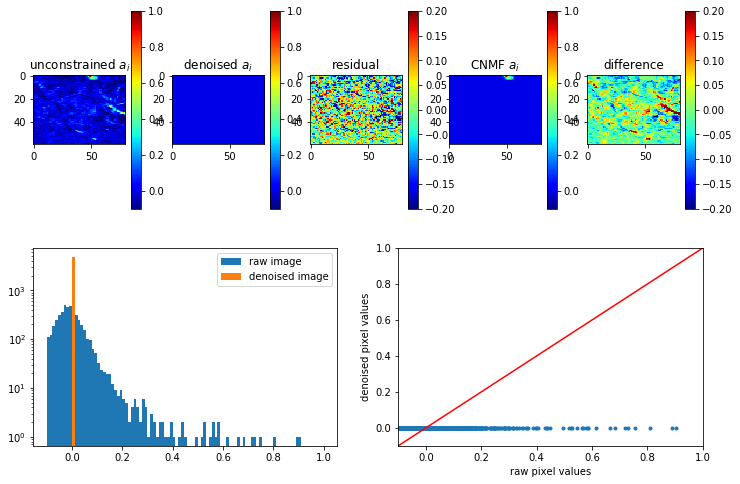

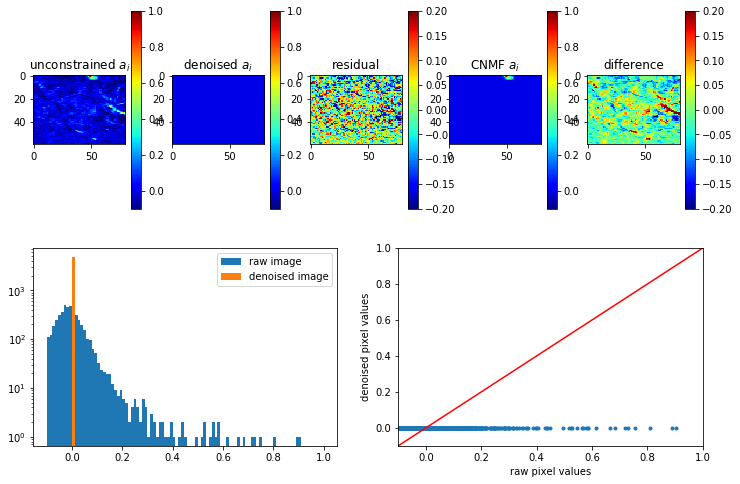

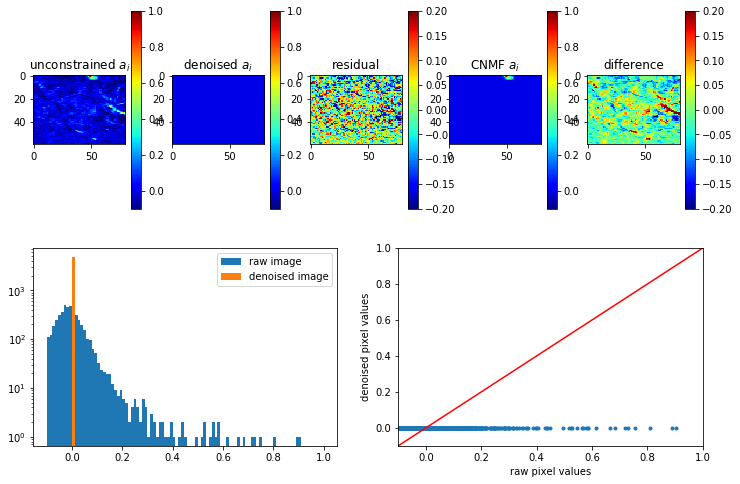

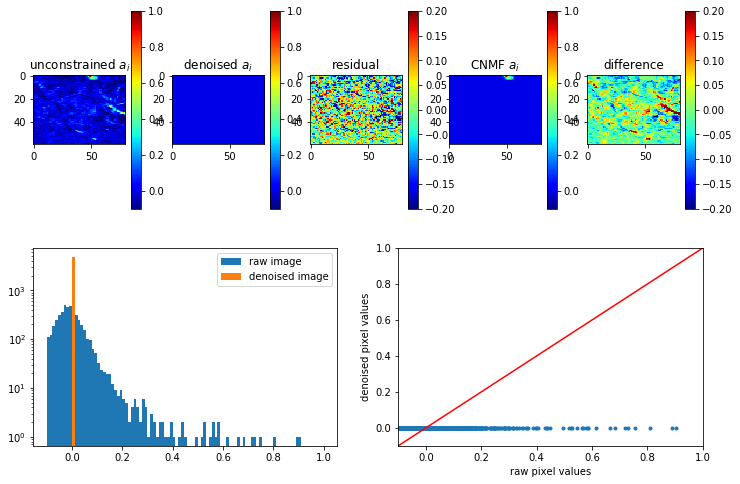

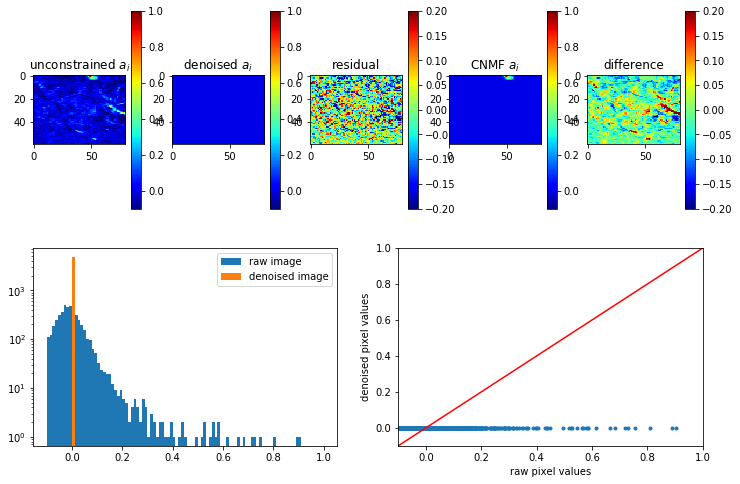

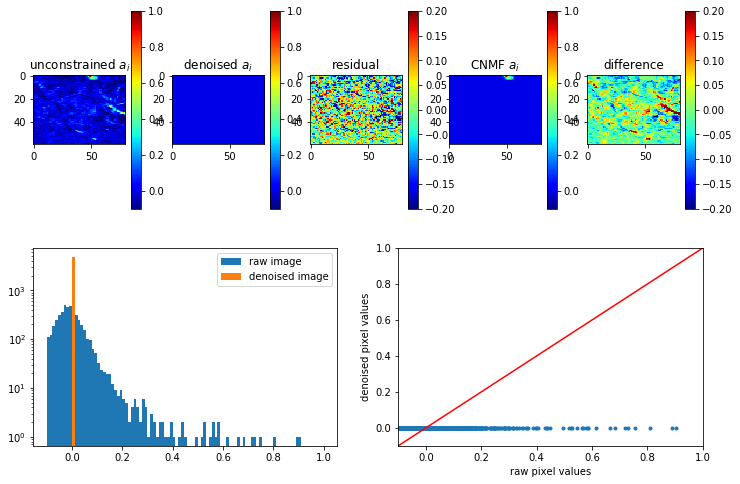

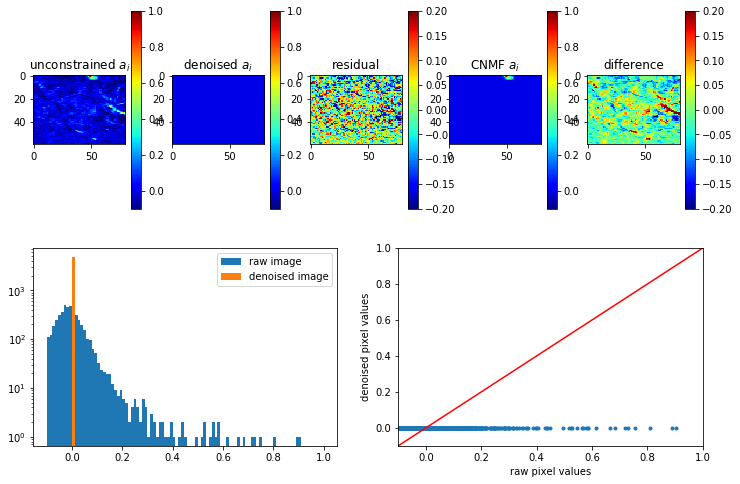

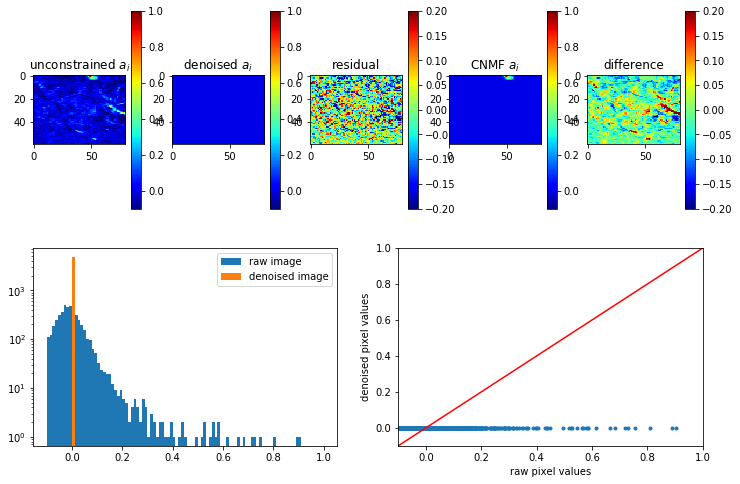

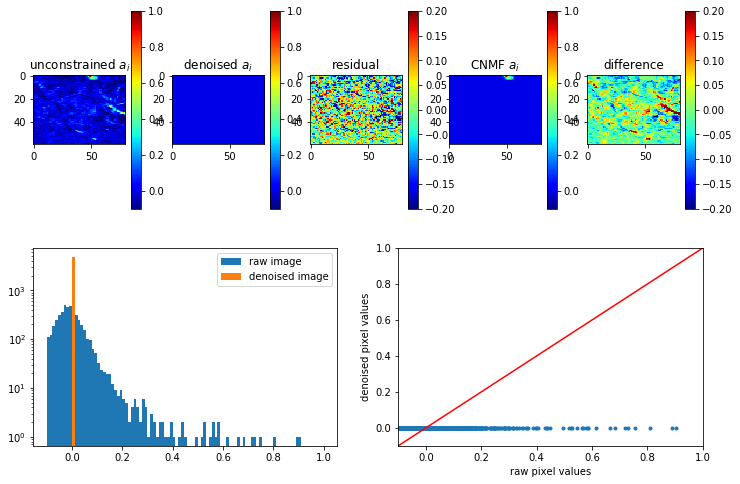

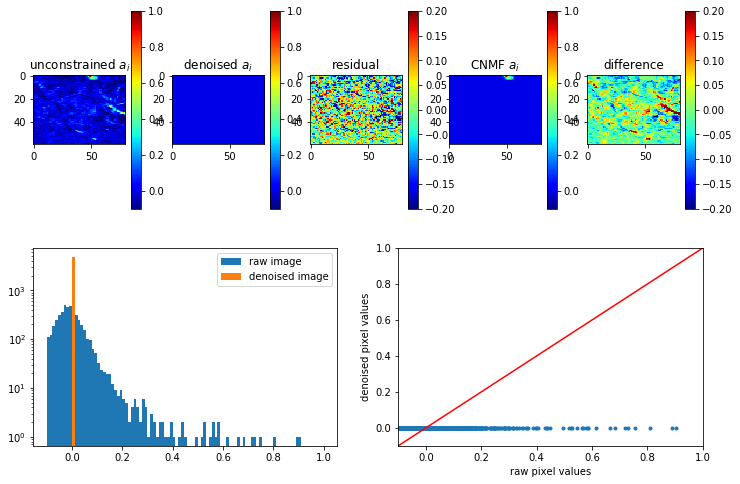

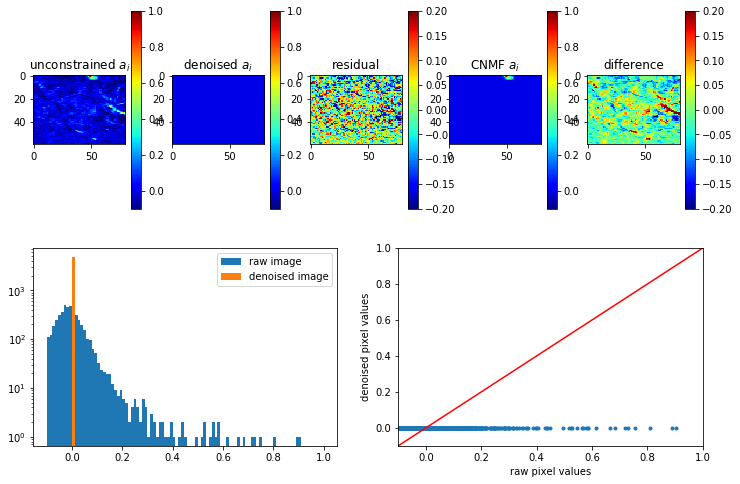

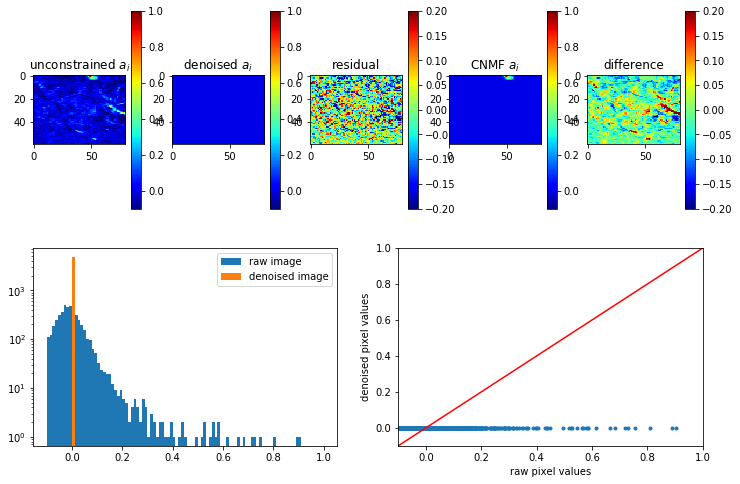

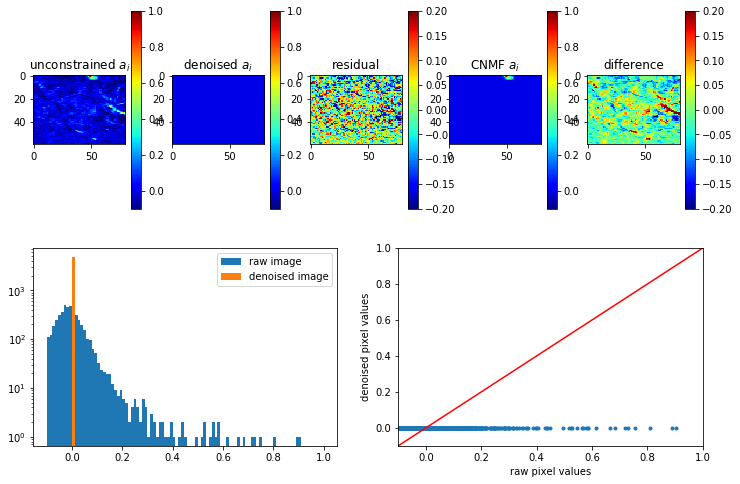

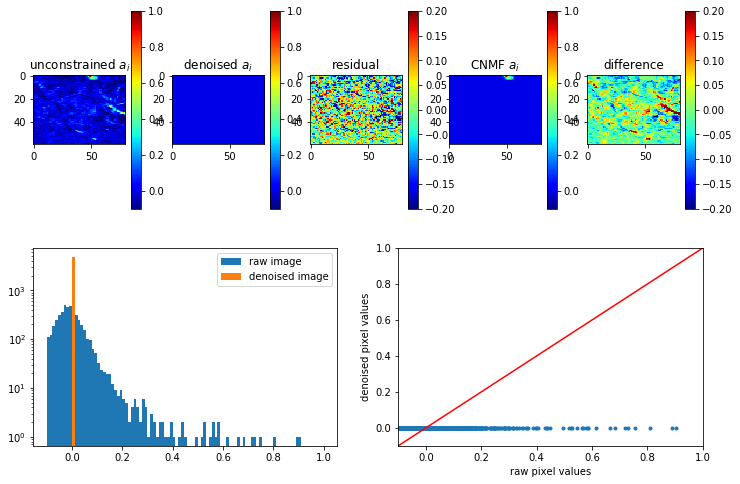

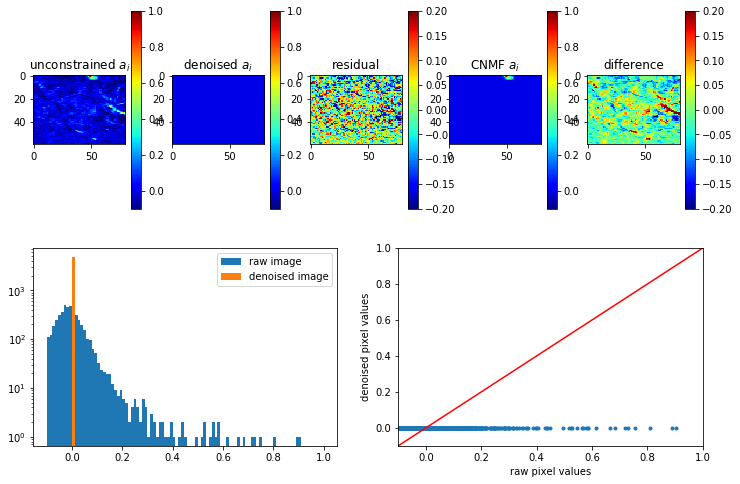

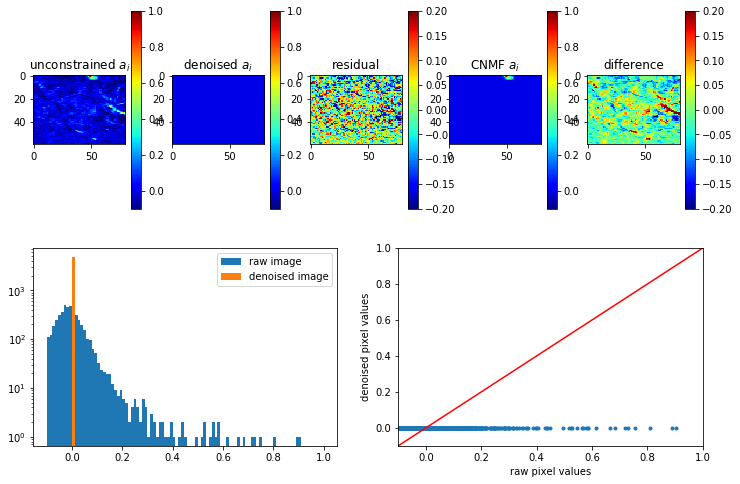

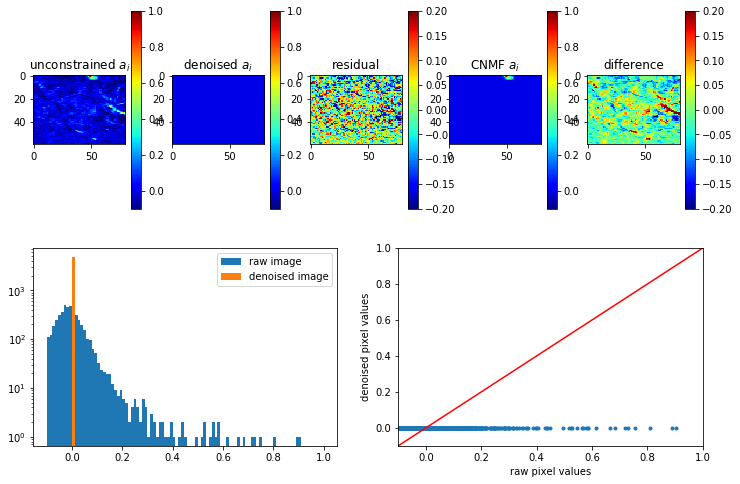

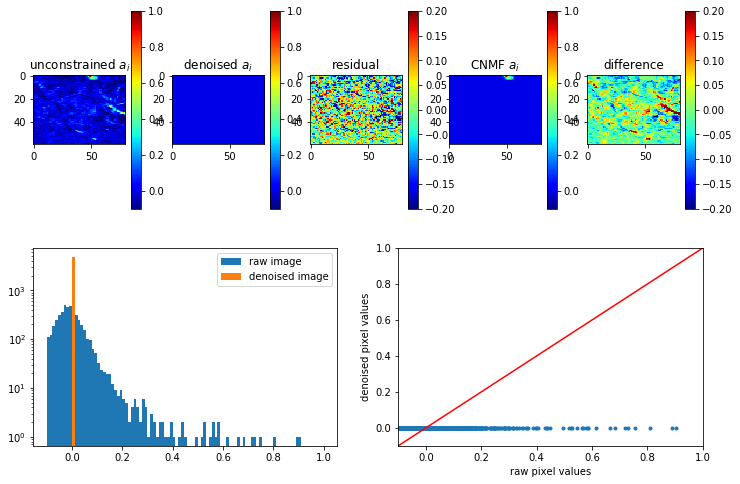

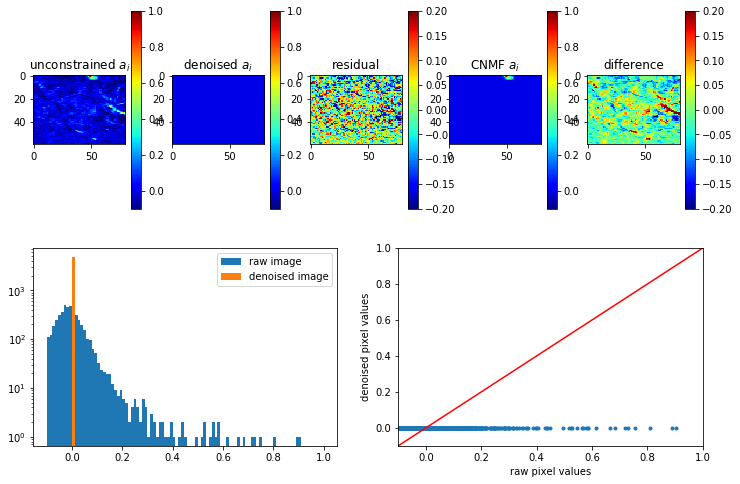

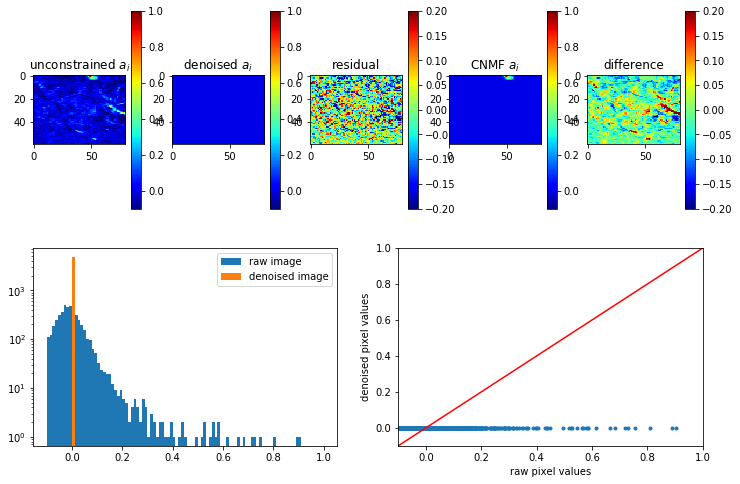

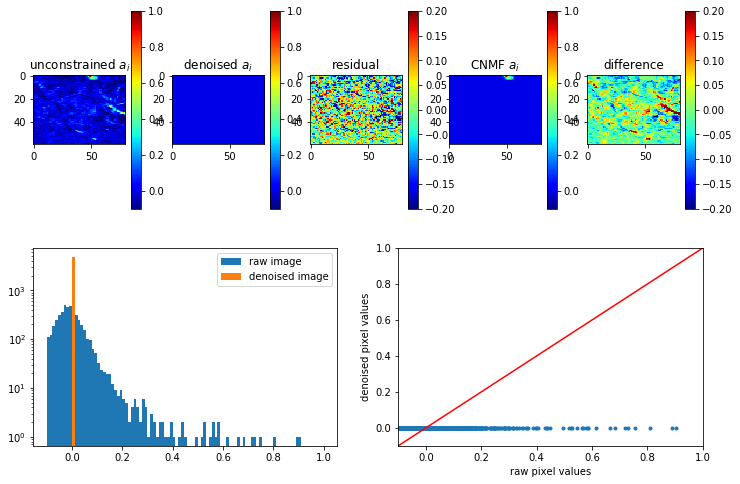

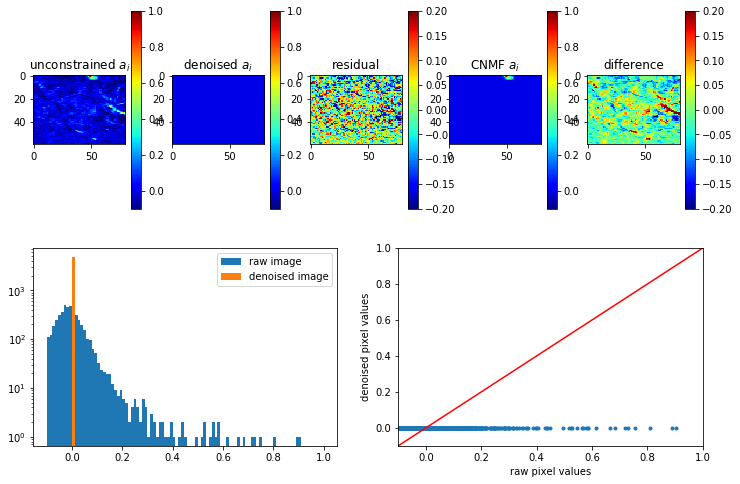

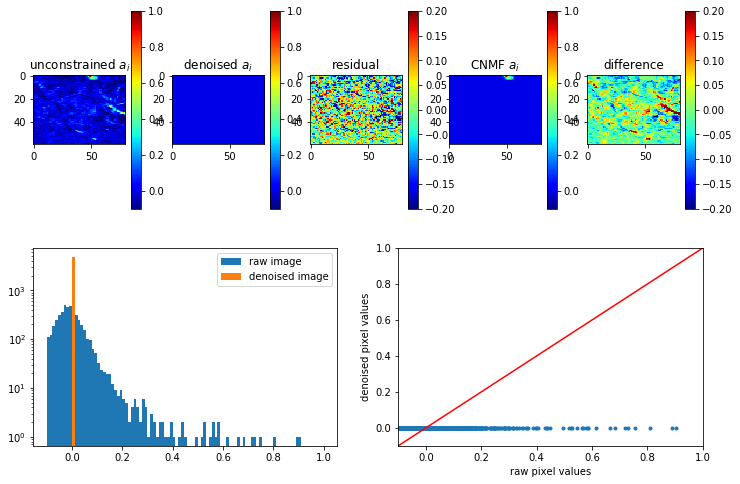

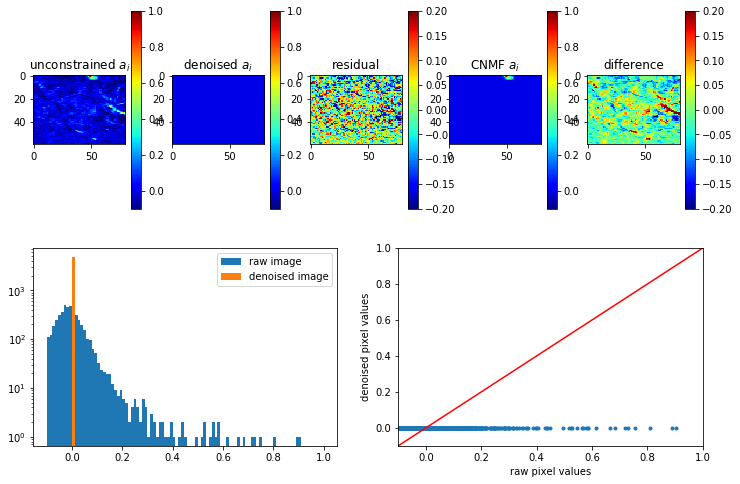

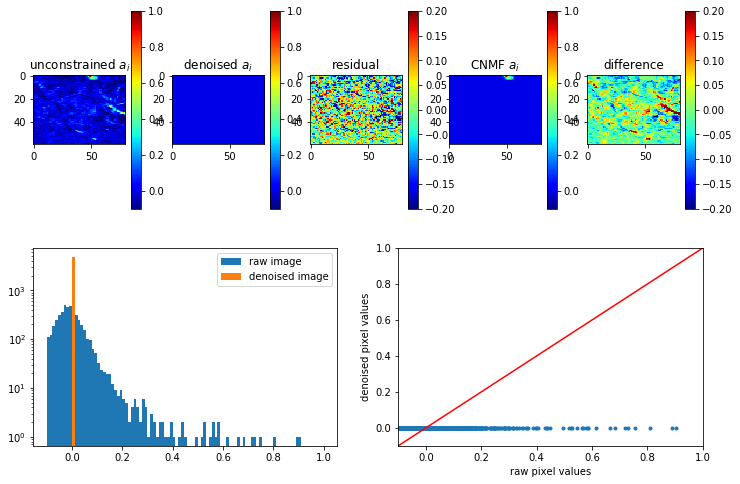

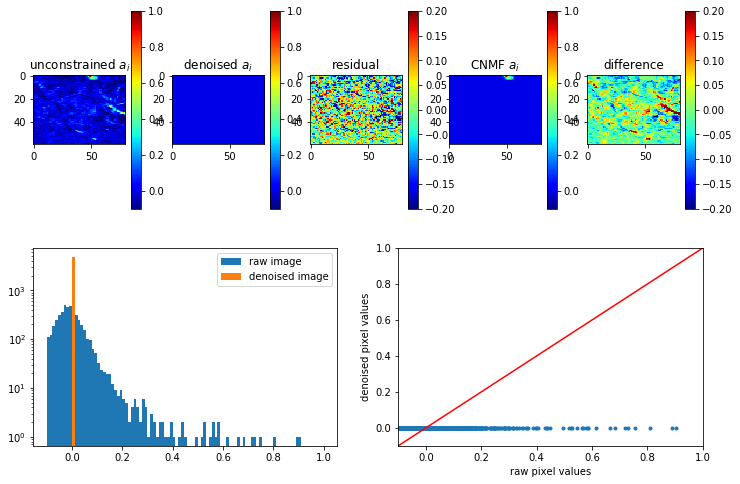

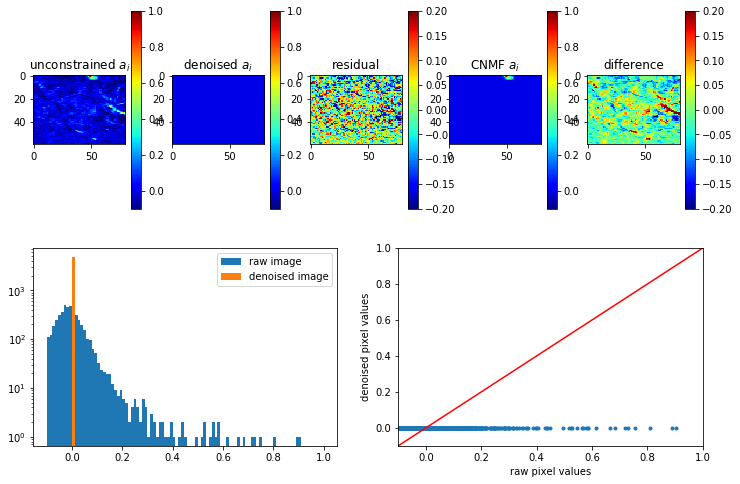

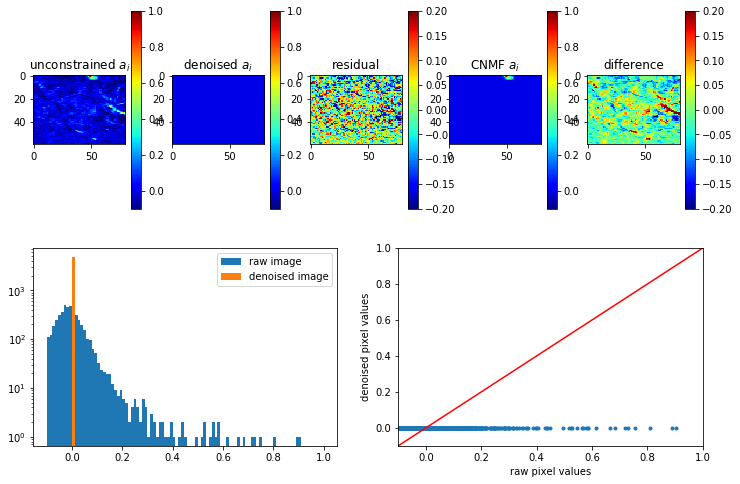

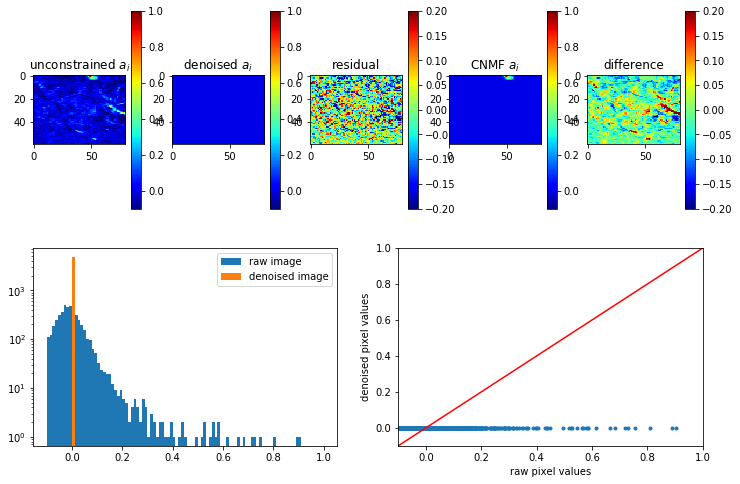

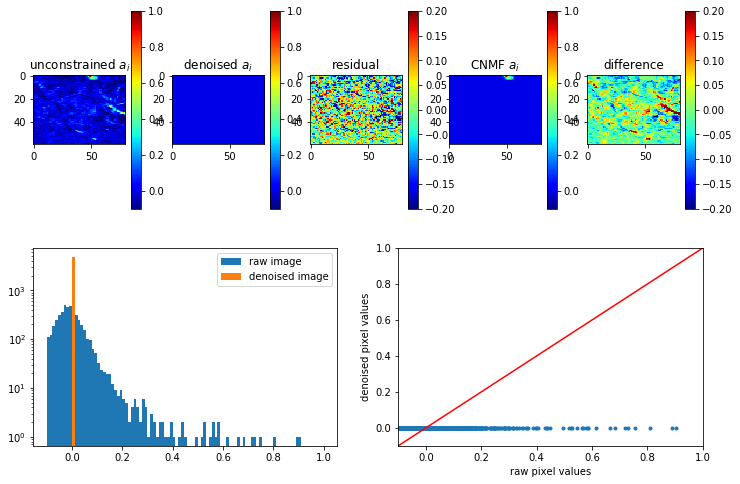

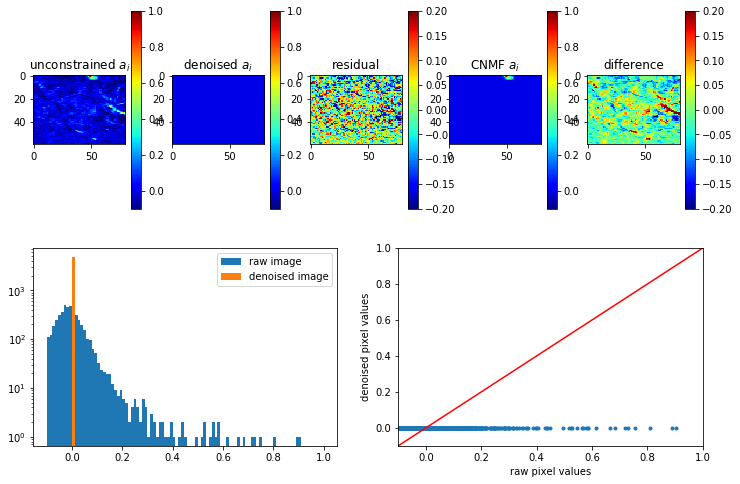

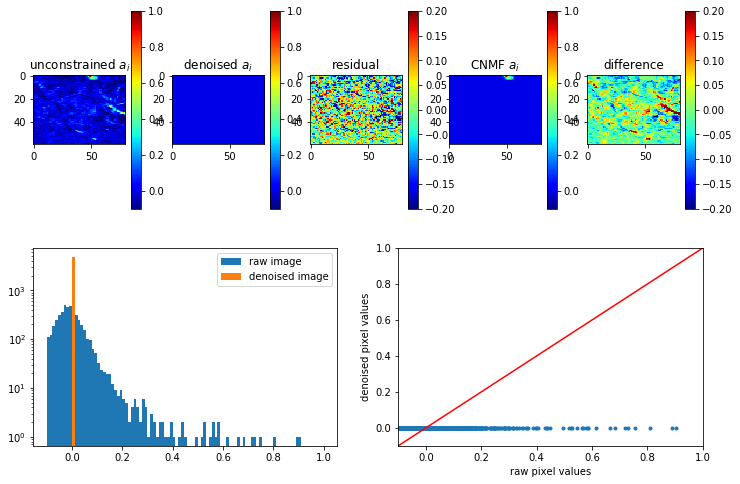

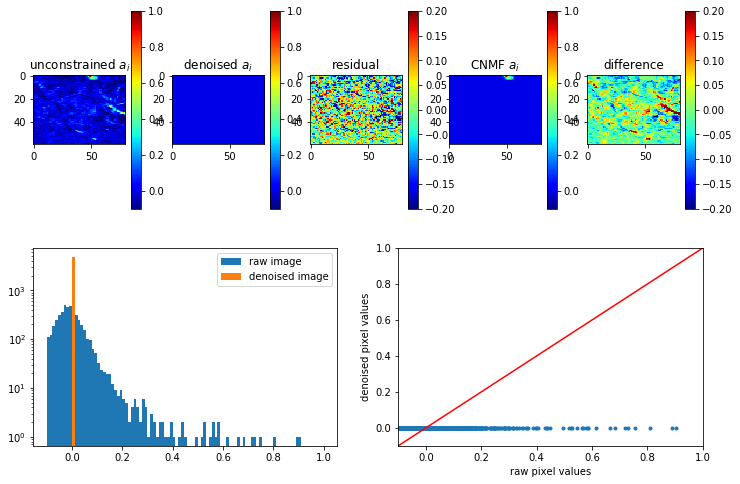

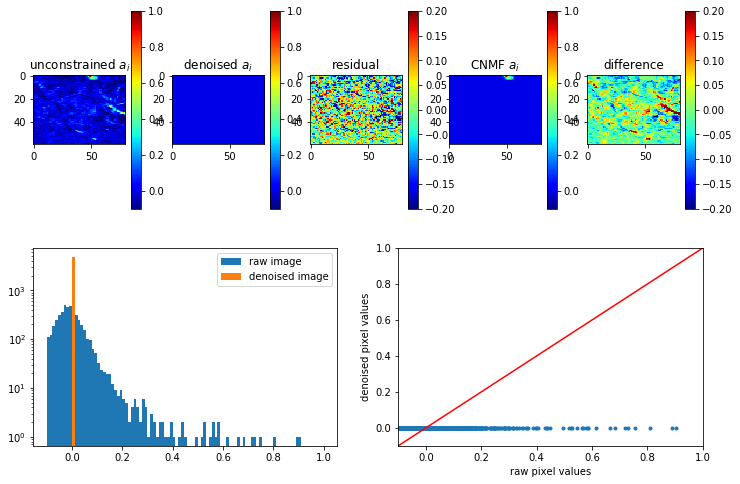

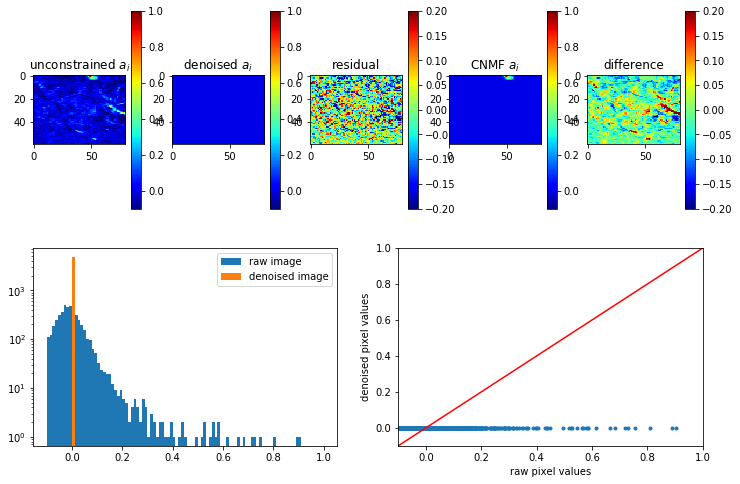

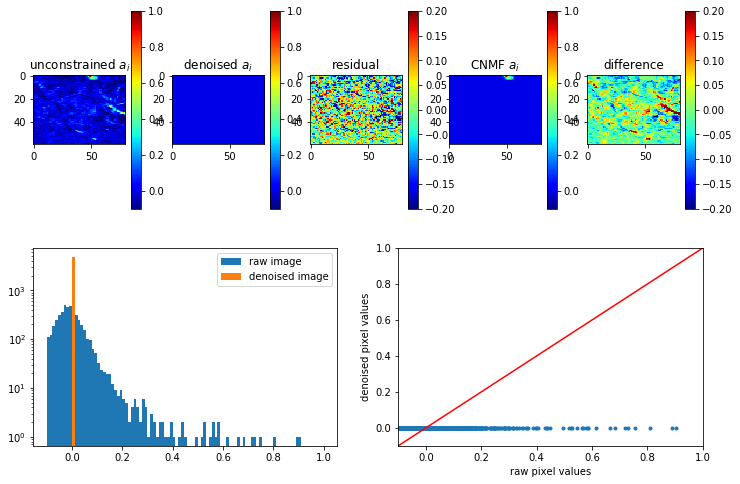

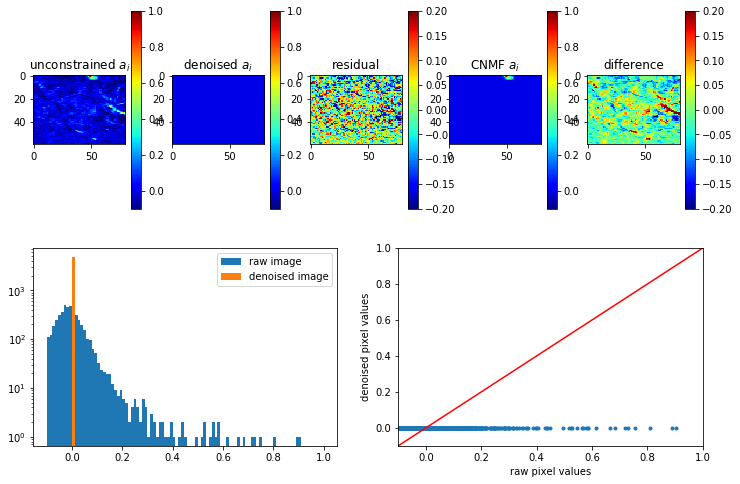

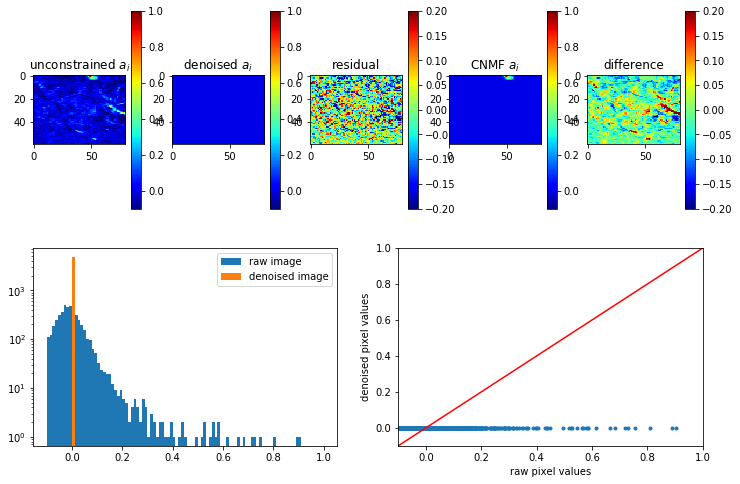

In [9]:
for i in range(38):
    img_raw, img_denoised = plot_2p_results(20)

Text(0.5, 1.0, 'NN-denoiser')

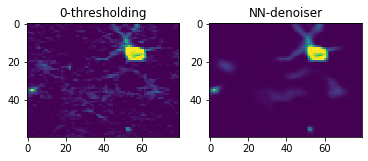

In [33]:
plt.subplot(121)
plt.imshow((img_raw * (img_raw>0)).squeeze(), clim=[0,1])
plt.title('0-thresholding')
plt.subplot(122)
plt.imshow(img_denoised.squeeze(), clim=[0,1])
plt.title('NN-denoiser')

# test baylor data 

In [34]:
real_data = sio.loadmat(os.path.join(data_path, 'baylor_data.mat'))
A = real_data['A']
A_corr = real_data['A_corr']
A_em = real_data['A_em']

In [35]:
def plot_baylor_results(neuron_id, plane_id, cmap='jet'): 
    img_raw = A_corr[:, :, plane_id, neuron_id].reshape(1,1, 58, 129)
    noise = img_raw[img_raw!=0].std()
    img_raw = img_raw / img_raw.max() 
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A[:, :, plane_id, neuron_id].squeeze()
    img_pi = A_em[:,:,plane_id, neuron_id].squeeze()
    
    imgs = [img_pi/img_pi.max(), img_ai/img_ai.max(), img_raw.squeeze(), img_denoised.squeeze(), img_output.squeeze()]
    titles = ['EM footprint', '2P footprint', 'corr. image', 'denoised corr. image', 'residual']
    fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    for img, title, ax in zip(imgs, titles, axs): 
        im = ax.imshow(img, cmap=cmap, clim=[-0.1, 0.5])
        ax.set_ylabel(title)
    

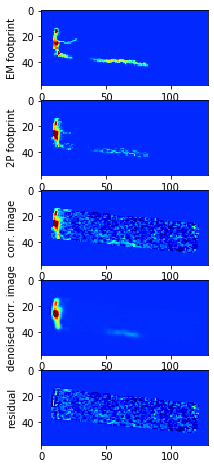

In [36]:
plot_baylor_results(5,2)

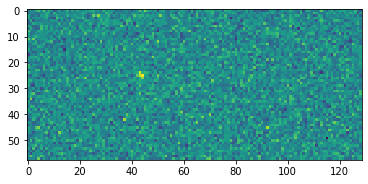

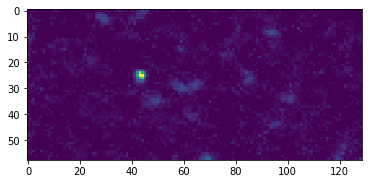

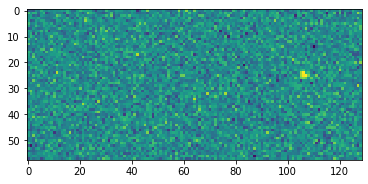

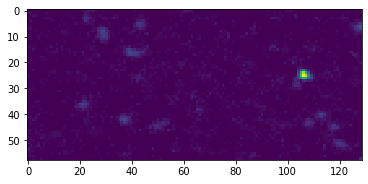

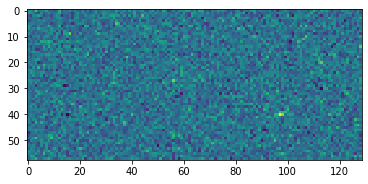

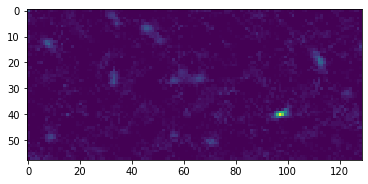

In [ ]:
#Here we visualize how well the model actually performs on the test data that we defined for it
for k in range(len(dataset_train)):
    img_val = torch.unsqueeze(dataset_val[k], 0)
    noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
    imgn_val = img_val + noise
    img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
    out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
    imgn_valCPU = imgn_val.detach().cpu().numpy()
    imgn_valCPU = imgn_valCPU.squeeze()
    out_valCPU = out_val.detach().cpu().numpy()
    out_valCPU = out_valCPU.squeeze()
    
    plt.figure()
    plt.imshow(imgn_valCPU)
    plt.figure()
    plt.imshow(out_valCPU)
    plt.show()
    input()
#     psnr_val += batch_PSNR(out_val, img_val, 1.)
# psnr_val /= len(dataset_val)